# BOM AusWave Dataset

Sourced from: http://www.bom.gov.au/nwp/doc/auswave/data.shtml

In [1]:
# set python to pick up local directory
from pathlib import Path
import sys
import os
path_root = Path(os.getcwd()).parents[0]
sys.path.append(str(path_root))
sys.path.append(str(Path(os.getcwd()).parents[1]))

%reload_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('always', category=FutureWarning)

In [2]:
from jax import config
config.update("jax_enable_x64", True)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [4]:
import jax
import jax.numpy as jnp
from jax import vmap, jit
from tensorflow_probability.substrates.jax import distributions as tfd
import optax
import equinox as eqx
from jax.lib import xla_bridge

In [5]:
from steinRF.utils import gp_cross_val, metric_model, run_hyperopt, mse, mae, train_test_split
from steinRF.baselines import build_svgp, build_train_svgp, svgp_predict, svgp_cross_val, svgp_nlpd
from steinRF.gp.models import *

In [6]:
jax.clear_caches()
print(f"device: {xla_bridge.get_backend().platform}")

device: gpu


## Data Preparation

In [7]:
key = jax.random.PRNGKey(2024)

In [8]:
ocean = pd.read_csv("data/ocean.csv")
X, y = jnp.array(ocean.iloc[:, :-1]), jnp.array(ocean["sig_wav_ht"])
y = y.reshape(-1)
X_scaler = MinMaxScaler().fit(X)
X = jnp.array(X_scaler.transform(X))
y_scaler = StandardScaler().fit(y.reshape(-1, 1))
y = jnp.array(y_scaler.transform(y.reshape(-1, 1)).reshape(-1))

X_train, X_val, y_train, y_val = train_test_split(key, X, y, test_size=ocean.shape[0] - 2000)
del X, y, ocean  # too big!

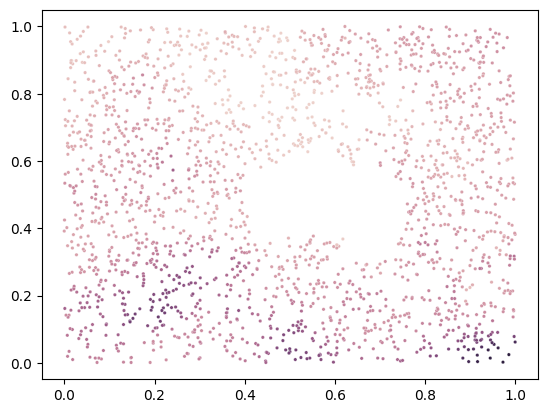

In [9]:
sns.scatterplot(x=X_train[:, 1], y=X_train[:, 0], hue=y_train, s=6)
plt.legend().remove()

## Hyperparameter Optimization

In [10]:
# total settings
diag_min, diag_max = 1e-4, 3e-1
epoch_min, epoch_max = 500, 4000
lr_min, lr_max = 1e-3, 4e-1
alpha_min, alpha_max = 0., 3.
q_min, q_max = 6, 10
s_vals = [0, 0.5, 1, 2]

# --------------------------------- Sparse Variational GP -------------------------------- #
def _svgp_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.get('R')
    diag = params.get('diag', None)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", 5e-4, 0.1, log=True)
    cv_params = {'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, **params}

    # run cross val
    cross_val_acc = svgp_cross_val(key, X, y, cv_params)
    return cross_val_acc


# ---------------------------------- RFF GP - RBF Kernel --------------------------------- #
def rff_rbf_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.pop('R')
    diag = params.pop('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    cv_params = {'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, **params}

    # run cross val
    cross_val_acc = gp_cross_val(build_train_rff_rbf, key, X, y, cv_params)
    return cross_val_acc


# --------------------------------------- RFF BASIC -------------------------------------- #
def rff_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.pop('R')
    diag = params.pop('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    cv_params = {'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, **params}

    # run cross val
    cross_val_acc = gp_cross_val(build_train_rff, key, X, y, cv_params)
    return cross_val_acc


def deep_rff_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.pop('R')
    diag = params.pop('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    cv_params = {'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, **params}

    # run cross val
    cross_val_acc = gp_cross_val(build_train_deep_rff, key, X, y, cv_params)
    return cross_val_acc


# --------------------------------------- STEIN RFF -------------------------------------- #
def srf_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.pop('R')

    diag = params.pop('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    lr_gd = params.pop('lr_gd', None)
    if lr_gd is None:
        lr_gd = trial.suggest_float("lr_gd", lr_min, lr_max, log=True)
    alpha = params.pop('alpha', None)
    if alpha is None:
        alpha = trial.suggest_float("alpha", alpha_min, alpha_max, step=0.2)
    s = params.pop('s', None)
    if s is None:
        s = trial.suggest_categorical("s", s_vals)
    cv_params = {
        'R': R, 'epochs': epochs, 'lr': lr, 'lr_gd': lr_gd, 'diag': diag, 'alpha': alpha, 
        's': s, **params
    }

    # run cross val
    cross_val_acc = gp_cross_val(build_train_srf, key, X, y, cv_params)
    return cross_val_acc


# ------------------------------------ MIXTURE KERNEL ------------------------------------ #
def mix_rff_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.pop('R')

    diag = params.pop('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    lr_gd = params.pop('lr_gd', None)
    if lr_gd is None:
        lr_gd = trial.suggest_float("lr_gd", lr_min, lr_max, log=True)
    alpha = params.pop('alpha', None)
    if alpha is None:
        alpha = trial.suggest_float("alpha", alpha_min, alpha_max, step=0.2)
    q = params.pop('q', None)
    if q is None:
        q = trial.suggest_int("q", q_min, q_max, step=2)
    s = params.pop('s', None)
    if s is None:
        s = trial.suggest_categorical("s", s_vals)

    cv_params = {
        'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, 'lr_gd': lr_gd,
        'alpha': alpha, 's': s, 'q': q, 'kernel': 'rbf', **params
    }

    # run cross val
    n_folds = params.pop('n_folds', 5)
    cross_val_acc = gp_cross_val(build_train_mix_rff, key, X, y, cv_params, n_folds=n_folds)
    return cross_val_acc


# ---------------------------------- DEEP MIXTURE KERNEL --------------------------------- #
def deep_mix_rff_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.pop('R')

    diag = params.pop('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    lr_gd = params.pop('lr_gd', None)
    if lr_gd is None:
        lr_gd = trial.suggest_float("lr_gd", lr_min, lr_max, log=True)
    alpha = params.pop('alpha', None)
    if alpha is None:
        alpha = trial.suggest_float("alpha", alpha_min, alpha_max, step=0.2)
    q = params.pop('q', None)
    if q is None:
        q = trial.suggest_int("q", q_min, q_max, step=2)
    s = params.pop('s', None)
    if s is None:
        s = trial.suggest_categorical("s", s_vals)

    cv_params = {
        'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, 'lr_gd': lr_gd,
        'alpha': alpha, 's': s, 'q': q, 'kernel': 'rbf', **params
    }

    # run cross val
    n_folds = params.pop('n_folds', 5)
    cross_val_acc = gp_cross_val(build_train_deep_mix_rff, key, X, y, cv_params, n_folds=n_folds)
    return cross_val_acc


### Run Optimization

In [11]:
n_trials = 30
R = 200
hparams = {}

#### Sparse-Variational GP

In [12]:
svgp_study = run_hyperopt(
    _svgp_cross_val, key, X_train, y_train, n_trials=15, diag=1e-4, R=R, epochs=1000, from_data=False
)
hparams["svgp"] = svgp_study.best_params

[I 2024-06-01 10:36:09,434] A new study created in memory with name: no-name-a601d985-b9b7-4dd7-a336-ebc8435bf074


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-06-01 10:37:32,250] Trial 0 finished with value: 0.0298025797335107 and parameters: {'lr': 0.0029685610977925676}. Best is trial 0 with value: 0.0298025797335107.
[I 2024-06-01 10:38:51,966] Trial 1 finished with value: 0.022277329347410574 and parameters: {'lr': 0.01137711883110033}. Best is trial 1 with value: 0.022277329347410574.
[I 2024-06-01 10:40:12,049] Trial 2 finished with value: 0.03736682825285214 and parameters: {'lr': 0.0020836851178828567}. Best is trial 1 with value: 0.022277329347410574.
[I 2024-06-01 10:41:32,137] Trial 3 finished with value: 0.026879042817624786 and parameters: {'lr': 0.004225154899832116}. Best is trial 1 with value: 0.022277329347410574.
[W 2024-06-01 10:43:01,761] Trial 4 failed with parameters: {'lr': 0.09950428266604187} because of the following error: The value nan is not acceptable.
[W 2024-06-01 10:43:01,762] Trial 4 failed with value nan.
[I 2024-06-01 10:44:21,705] Trial 5 finished with value: 0.01993394332072563 and parameters: {'l

#### RFF with RBF

In [12]:
rff_rbf_study = run_hyperopt(
    rff_rbf_cross_val, key, X_train, y_train, n_trials=20, R=R, epochs=1000
)
hparams["rff_rbf"] = rff_rbf_study.best_params

[I 2024-05-31 16:01:57,731] A new study created in memory with name: no-name-9b305059-1b85-4e75-a91f-f2f3a5409316


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-31 16:03:25,040] Trial 0 finished with value: 0.894270623419098 and parameters: {'diag': 0.000653715627107594, 'lr': 0.02498979117165308}. Best is trial 0 with value: 0.894270623419098.
[I 2024-05-31 16:04:50,784] Trial 1 finished with value: 0.8885355863007944 and parameters: {'diag': 0.0433393003023098, 'lr': 0.01080812567844596}. Best is trial 1 with value: 0.8885355863007944.
[I 2024-05-31 16:06:17,280] Trial 2 finished with value: 0.5350974303721407 and parameters: {'diag': 0.0005143785172899594, 'lr': 0.06464109616317773}. Best is trial 2 with value: 0.5350974303721407.
[I 2024-05-31 16:07:43,862] Trial 3 finished with value: 0.9320015778894082 and parameters: {'diag': 0.0012266071446377814, 'lr': 0.00472931059706632}. Best is trial 2 with value: 0.5350974303721407.
[I 2024-05-31 16:09:10,469] Trial 4 finished with value: 0.8893961506698911 and parameters: {'diag': 0.0036430337485645788, 'lr': 0.012331769238056385}. Best is trial 2 with value: 0.5350974303721407.
[I 20

#### Basic RFF GP

In [12]:
rff_study = run_hyperopt(
    rff_cross_val, key, X_train, y_train, n_trials=20, R=R, epochs=1000, from_data=False, diag=1e-4
)
hparams["rff"] = rff_study.best_params

[I 2024-05-31 22:04:45,475] A new study created in memory with name: no-name-14bee646-7764-4fe1-ad6e-59bb935a4c49


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-31 22:05:44,750] Trial 0 finished with value: 1.7994169343192252 and parameters: {'diag': 0.0029829342835350926, 'lr': 0.0037604262005157315}. Best is trial 0 with value: 1.7994169343192252.
[I 2024-05-31 22:06:40,804] Trial 1 finished with value: 2.040828370962822 and parameters: {'diag': 0.00045029753781992233, 'lr': 0.006904457241037273}. Best is trial 0 with value: 1.7994169343192252.
[I 2024-05-31 22:07:36,606] Trial 2 finished with value: 1.07447018543815 and parameters: {'diag': 0.03533637097570331, 'lr': 0.013685030070509458}. Best is trial 2 with value: 1.07447018543815.
[I 2024-05-31 22:08:31,568] Trial 3 finished with value: 1.210131168711035 and parameters: {'diag': 0.015411407831374038, 'lr': 0.008211205657761577}. Best is trial 2 with value: 1.07447018543815.
[I 2024-05-31 22:09:26,740] Trial 4 finished with value: 1.1597772529669712 and parameters: {'diag': 0.07079929901043701, 'lr': 0.0010632707990353386}. Best is trial 2 with value: 1.07447018543815.
[I 2024

#### Deep RFF GP

In [15]:
deep_rff_study = run_hyperopt(
    deep_rff_cross_val, key, X_train, y_train, n_trials=20, R=R, epochs=1000, diag=1e-4, out_dim=10,
    gd_params=lambda t: [t.kernel.transform.layers, t.kernel.transform.scale]
)
hparams["rff"] = deep_rff_study.best_params

[I 2024-06-01 11:39:38,157] A new study created in memory with name: no-name-8db95713-19b8-4e05-ba56-817c85578f9e


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-06-01 11:40:40,894] Trial 0 finished with value: 0.017603246581908084 and parameters: {'lr': 0.0014946064851952847}. Best is trial 0 with value: 0.017603246581908084.
[I 2024-06-01 11:41:41,437] Trial 1 finished with value: 0.01881842442606584 and parameters: {'lr': 0.0011366213056981332}. Best is trial 0 with value: 0.017603246581908084.
[I 2024-06-01 11:42:41,925] Trial 2 finished with value: 0.6206046705947952 and parameters: {'lr': 0.22567395335890508}. Best is trial 0 with value: 0.017603246581908084.
[I 2024-06-01 11:43:42,504] Trial 3 finished with value: 0.02005460407616218 and parameters: {'lr': 0.004075568087789277}. Best is trial 0 with value: 0.017603246581908084.
[I 2024-06-01 11:44:43,094] Trial 4 finished with value: 0.035571080472005925 and parameters: {'lr': 0.0056062829109382924}. Best is trial 0 with value: 0.017603246581908084.
[I 2024-06-01 11:45:43,696] Trial 5 finished with value: 0.03682021294841189 and parameters: {'lr': 0.021590671407779122}. Best is t

NameError: name 'rff_study' is not defined

#### Stein Random Features

In [14]:
srf_study = run_hyperopt(
    srf_cross_val, key, X_train, y_train, n_trials=25, R=R, epochs=1000, from_data=False, diag=1e-4,
    gd_params=lambda t: [t.kernel.transform.scale]
)
hparams["srf"] = srf_study.best_params

[I 2024-06-01 11:13:59,332] A new study created in memory with name: no-name-8f5b570c-bfc6-4bca-969e-301e29b55023


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2024-06-01 11:15:00,782] Trial 0 finished with value: 1.4345711449812661 and parameters: {'lr': 0.06573056176099794, 'lr_gd': 0.008678362474756538, 'alpha': 0.2, 's': 2}. Best is trial 0 with value: 1.4345711449812661.
[I 2024-06-01 11:16:01,668] Trial 1 finished with value: 1.303881690111344 and parameters: {'lr': 0.29307617667678176, 'lr_gd': 0.0867289849550313, 'alpha': 0.8, 's': 0.5}. Best is trial 1 with value: 1.303881690111344.
[I 2024-06-01 11:17:02,670] Trial 2 finished with value: 2.0785246902756254 and parameters: {'lr': 0.005404730467879231, 'lr_gd': 0.01010505535165661, 'alpha': 0.2, 's': 1}. Best is trial 1 with value: 1.303881690111344.
[I 2024-06-01 11:18:03,407] Trial 3 finished with value: 1.7107411667463035 and parameters: {'lr': 0.23799419575344266, 'lr_gd': 0.006208923199129063, 'alpha': 1.0, 's': 0}. Best is trial 1 with value: 1.303881690111344.
[I 2024-06-01 11:19:04,509] Trial 4 finished with value: 1.394350998192931 and parameters: {'lr': 0.0386556933932454

#### Mixture SRFR

In [14]:
mix_rff_study = run_hyperopt(
    mix_rff_cross_val, key, X_train, y_train, n_trials=30, R=R, epochs=1000, from_data=False, 
    lr_gd=0.1, diag=1e-4,
)

[I 2024-06-01 00:15:08,029] A new study created in memory with name: no-name-530240e0-198a-40a8-94e2-9dc7d947b211


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2024-06-01 00:25:28,908] Trial 0 finished with value: 0.7863978158433179 and parameters: {'lr': 0.15021196092108707, 'alpha': 0.4, 'q': 8, 's': 1}. Best is trial 0 with value: 0.7863978158433179.
[I 2024-06-01 00:32:09,106] Trial 1 finished with value: 0.9143324007702518 and parameters: {'lr': 0.008179387094223051, 'alpha': 2.0, 'q': 6, 's': 0.5}. Best is trial 0 with value: 0.7863978158433179.
[I 2024-06-01 00:38:48,400] Trial 2 finished with value: 1.011741988740271 and parameters: {'lr': 0.29117125302224484, 'alpha': 2.0, 'q': 6, 's': 1}. Best is trial 0 with value: 0.7863978158433179.
[I 2024-06-01 00:53:26,686] Trial 3 finished with value: 1.0135776696175323 and parameters: {'lr': 0.37920705859289233, 'alpha': 0.6000000000000001, 'q': 10, 's': 0.5}. Best is trial 0 with value: 0.7863978158433179.
[I 2024-06-01 01:03:48,427] Trial 4 finished with value: 0.849022260484483 and parameters: {'lr': 0.004394579664550844, 'alpha': 0.4, 'q': 8, 's': 1}. Best is trial 0 with value: 0.786

#### Deep Mixture SRFR

In [ ]:
deep_mix_rff_study = run_hyperopt(
    deep_mix_rff_cross_val, key, X_train, y_train, out_dim=10, n_trials=10, R=R, epochs=1000,
    diag=1e-4,
)

## Define and Run Experiment

In [18]:
def experiment_run(exp_key, X, y, scaler, params, R, restarts=1):
    
    # split data
    X_tr, X_test, y_tr, y_test = train_test_split(exp_key, X, y, test_size=1000)

    ############ SVGP ############
    svgp, _ = build_train_svgp(exp_key, X_tr, y_tr, R=R, **params["svgp"])
    svgp_preds, svgp_sd = svgp_predict(svgp, X_test)
    svgp_metrics = metric_model(y_test, svgp_preds, svgp_sd, scaler=scaler)
    svgp_metrics = jnp.concatenate([svgp_metrics, jnp.atleast_1d(svgp_nlpd(svgp, X_test, y_test))])

    ############ RFF RBF ############
    rff_rbf_gp, _ = build_train_rff_rbf(exp_key, X_tr, y_tr, R=R, restarts=restarts, **params["rff_rbf"])
    rff_rbf_preds, rff_rbf_sd = rff_rbf_gp.condition(y_tr, X_test)
    rff_rbf_metrics = metric_model(y_test, rff_rbf_preds, rff_rbf_sd, scaler=scaler)
    rff_rbf_metrics = jnp.concatenate([
        rff_rbf_metrics, jnp.atleast_1d(rff_rbf_gp.nlpd(y_tr, X_test, y_test))
    ])

    ############ RFF ############
    rff_gp, _ = build_train_rff(exp_key, X_tr, y_tr, R=R, restarts=restarts, **params["rff"])
    rff_preds, rff_sd = rff_gp.condition(y_tr, X_test)
    rff_metrics = metric_model(y_test, rff_preds, rff_sd, scaler=scaler)
    rff_metrics = jnp.concatenate([
        rff_metrics, jnp.atleast_1d(rff_gp.nlpd(y_tr, X_test, y_test))
    ])

    ############ DEEP RFF ############
    deep_rff_gp, _ = build_train_deep_rff(exp_key, X_tr, y_tr, R=R, restarts=restarts, **params["deep_rff"])
    deep_rff_preds, deep_rff_sd = deep_rff_gp.condition(y_tr, X_test)
    deep_rff_metrics = metric_model(y_test, deep_rff_preds, deep_rff_sd, scaler=scaler)
    deep_rff_metrics = jnp.concatenate([
        deep_rff_metrics, jnp.atleast_1d(deep_rff_gp.nlpd(y_tr, X_test, y_test))
    ])

    ############ RFF-Q ############
    # RFF with the equilvalent number of R as the computational complexity of the mixture.
    q = params["mix_rff"]["q"]
    R_equiv_q = int((q * R**3)**(1/3))
    qrff_gp, _ = build_train_rff(exp_key, X_tr, y_tr, R=R_equiv_q, restarts=restarts, **params["rff"])
    qrff_preds, qrff_sd = qrff_gp.condition(y_tr, X_test)
    qrff_metrics = metric_model(y_test, qrff_preds, qrff_sd, scaler=scaler)
    qrff_metrics = jnp.concatenate([
        qrff_metrics, jnp.atleast_1d(qrff_gp.nlpd(y_tr, X_test, y_test))
    ])

    ############ SRF ############
    srf_gp, _ = build_train_srf(exp_key, X_tr, y_tr, R=R, restarts=restarts, **params["srf"])
    srf_preds, srf_sd = srf_gp.condition(y_tr, X_test)
    srf_metrics = metric_model(y_test, srf_preds, srf_sd, scaler=scaler)
    srf_metrics = jnp.concatenate([
        srf_metrics, jnp.atleast_1d(srf_gp.nlpd(y_tr, X_test, y_test))
    ])    

    ############ MIX ############
    mix_gp, _ = build_train_mix_rff(exp_key, X_tr, y_tr, R=R, restarts=restarts, **params["mix_rff"])
    mix_preds, mix_sd = mix_gp.condition(y_tr, X_test)
    mix_metrics = metric_model(y_test, mix_preds, mix_sd, scaler=scaler)
    mix_metrics = jnp.concatenate([
        mix_metrics, jnp.atleast_1d(mix_gp.nlpd(y_tr, X_test, y_test))
    ])

    ############ DEEP MIX ############
    deep_mix_gp, _ = build_train_deep_mix_rff(exp_key, X_tr, y_tr, R=R, restarts=restarts, **params["deep_mix_rff"])
    deep_mix_preds, deep_mix_sd = deep_mix_gp.condition(y_tr, X_test)
    deep_mix_metrics = metric_model(y_test, deep_mix_preds, deep_mix_sd, scaler=scaler)
    deep_mix_metrics = jnp.concatenate([
        deep_mix_metrics, jnp.atleast_1d(deep_mix_gp.nlpd(y_tr, X_test, y_test))
    ])

    metrics = {
        "seed": int(exp_key[1]),
        "svgp": svgp_metrics,
        "rff_rbf": rff_rbf_metrics,
        "rff": rff_metrics,
        "deep_rff": deep_rff_metrics,
        "qrff": qrff_metrics,
        "srf": srf_metrics,
        "mix": mix_metrics,
        "deep_mix": deep_mix_metrics
    }

    return metrics

In [19]:
def multi_run(multi_key, X, y, scaler, params, R, n_runs=5):
    metrics = []
    run_keys = jax.random.split(multi_key, n_runs)

    for i in range(n_runs):
        print(f"Running experiment {i+1} of {n_runs}")
        sub_inds = jax.random.choice(run_keys[i], jnp.arange(X.shape[0]), shape=(6000,), replace=False)
        X_sub, y_sub = X[sub_inds], y[sub_inds]
        run_res = experiment_run(run_keys[i], X_sub, y_sub, scaler, params, R)
        metrics.append(run_res)
        print(run_res)
    
    return metrics

### Run

In [20]:
# reload data for splits
ocean = pd.read_csv("data/ocean.csv")
X, y = jnp.array(ocean.iloc[:, :-1]), jnp.array(ocean["sig_wav_ht"])
y = y.reshape(-1)
X_scaler = MinMaxScaler().fit(X)
X = jnp.array(X_scaler.transform(X))
y_scaler = StandardScaler().fit(y.reshape(-1, 1))
y = jnp.array(y_scaler.transform(y.reshape(-1, 1)).reshape(-1))

In [21]:
KEY, subkey = jax.random.split(jax.random.PRNGKey(2024))

params = {
    "svgp": {'lr': 0.030410454375133907, 'epochs': 1000, 'diag': 1e-4, 'from_data': False},  # done
    "rff_rbf": {'diag': 0.00014210362205954502, 'lr': 0.3866967094008227, 'epochs': 1000},  # done
    "rff": {'diag': 0.2890802632177069, 'lr': 0.3513927781022791, 'epochs': 1000, 'from_data': False},  # done
    "deep_rff": {'diag': 1e-4, 'epochs': 1000, 'out_dim': 10, 'lr': 0.0031816943829226932},
    "srf": {
        'diag': 1e-4, 'lr': 0.001254733557288391, 'lr_gd': 0.39356085614520586, 'alpha': 3.0, 's': 1,
        'epochs': 1000, 'from_data': False, 'gd_params': lambda t: [t.kernel.transform.scale]
    },
    "mix_rff": {
        'lr': 0.20054415081516902, 'alpha': 3.0, 'q': 8, 's': 0.5, 'diag': 1e-4,
        'epochs': 1000, 'from_data': False, 'init_ls': True, 'lr_gd': 0.1
    },
    'deep_mix_rff': {
        'lr': 0.0020987185371676947, 'lr_gd': 0.12284882037724744, 'alpha': 2.6, 'q': 10, 's': 0.5, 
        'diag': 1e-4, 'epochs': 1000, 'out_dim': 10, 
    }
}

In [22]:
# experiment_run(subkey, X, y, y_scaler, params, R=200)
res = multi_run(KEY, X, y, y_scaler, params, R=200, n_runs=10)

Running experiment 1 of 10
{'seed': 3007921430, 'svgp': Array([3.65771460e-02, 1.39601683e-01, 9.56000030e-01, 7.33427992e-04,
       3.05887894e+03], dtype=float64), 'rff_rbf': Array([ 1.78914588e-02,  9.60042404e-02,  2.55000025e-01, -1.78089505e-03,
        2.17251040e+04], dtype=float64), 'rff': Array([ 1.09112166e+00,  7.17854708e-01,  8.84000063e-01, -3.57303815e-02,
        1.16277492e+03], dtype=float64), 'deep_rff': Array([1.95922821e-02, 8.97087927e-02, 2.62000024e-01, 1.56356512e-04,
       3.29611165e+04], dtype=float64), 'qrff': Array([ 2.77457726e-02,  1.22494794e-01,  1.00000000e+00, -4.53049996e-04,
        3.26035739e+02], dtype=float64), 'srf': Array([ 1.49134590e-02,  7.99497562e-02,  2.54000008e-01, -1.84964097e-04,
        2.31236348e+04], dtype=float64), 'mix': Array([1.68539908e-02, 9.12437463e-02, 9.06000018e-01, 4.55717687e-04,
       5.83204578e+04], dtype=float64), 'deep_mix': Array([ 8.96074657e-03,  6.45351323e-02,  6.38000011e-01, -1.59255613e-03,
        

In [23]:
res_df = []
for exp in res:
    res_df.extend([[k, *v.tolist()] for k,v in exp.items() if k != "seed"])
res_df = pd.DataFrame(res_df, columns=["model", "mse", "mae", "cal", "z", "nlpd"])
res_df.to_csv("results_cr.csv", index=False)

## Evaluate

In [52]:
res_df = pd.read_csv("results_cr.csv")

names = {
    "rff": "SSGP",
    "deep_rff": "SSGP-Deep",
    "rff_rbf": "SSGP-RBF",
    "svgp": "SVGP",
    "srf": "SSGP-SVGD",
    "qrff": "SSGP-$R^*$",
    "mix": "M-SRFR (Ours)",
    "deep_mix": "Deep M-SRFR (Ours)",
}

res_df["model"] = res_df["model"].apply(lambda x: names[x])
res_df["rmse"] = np.sqrt(res_df["mse"])
res_df["log_mse"] = np.log(res_df["mse"])

### Metrics

In [53]:
sum_df = res_df.groupby("model").agg(["mean", "std"])
sum_df.columns = sum_df.columns.map(lambda x: '_'.join(x) if isinstance(x, tuple) else x)
sum_df = sum_df.sort_values("rmse_mean", ascending=True).reset_index()
sum_df[['model', 'rmse_mean', 'rmse_std', "nlpd_mean", "nlpd_std"]]

,model,rmse_mean,rmse_std,nlpd_mean,nlpd_std
0,Deep M-SRFR (Ours),0.098250,0.008945,16533.267060,1918.266663
1,M-SRFR (Ours),0.132992,0.003709,57406.336124,3911.912668
2,SSGP-Deep,0.135942,0.015809,35303.740332,7173.546190
3,SSGP-SVGD,0.146239,0.050583,38921.006184,44443.966569
4,SSGP-RBF,0.153725,0.048419,28201.940253,25192.361130
5,SVGP,0.197467,0.019217,3016.040506,1813.306030
6,SSGP,0.309395,0.296917,445.350089,269.739279
7,SSGP-$R^*$,0.438251,0.577089,654.276857,702.415403


Text(0.5, 1.0, '$\\it{AusWave}$ Dataset Error')

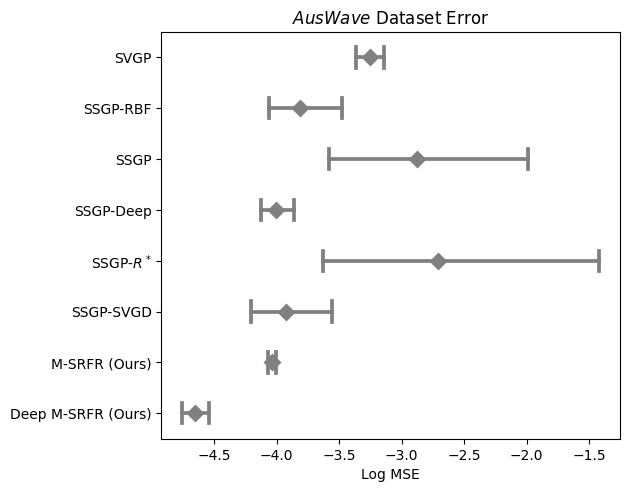

In [57]:
unique_models = res_df["model"].unique()
colors = sns.color_palette("hls", len(unique_models))

pointplot = sns.pointplot(
    data=res_df, x="log_mse", y="model", #hue="model",
    errorbar="ci", capsize=.4,
    legend=False, color="grey", #palette="winter", color=".5",
    linestyle="none", marker="D",
)
plt.xlabel("Log MSE")
plt.ylabel("")
plt.tight_layout()
pointplot.set_title("$\\it{AusWave}$ Dataset Error")

### Learned Kernels

In [ ]:
from steinRF.utils import mixture_pred_dists, plot_kernel_mixture, plot_mixture_preds

In [ ]:
rff_gp, single_dist, mix_gp, mixture_dist, y_test = mixture_pred_dists(key, X, y, params, R=100, test_size=0.1)

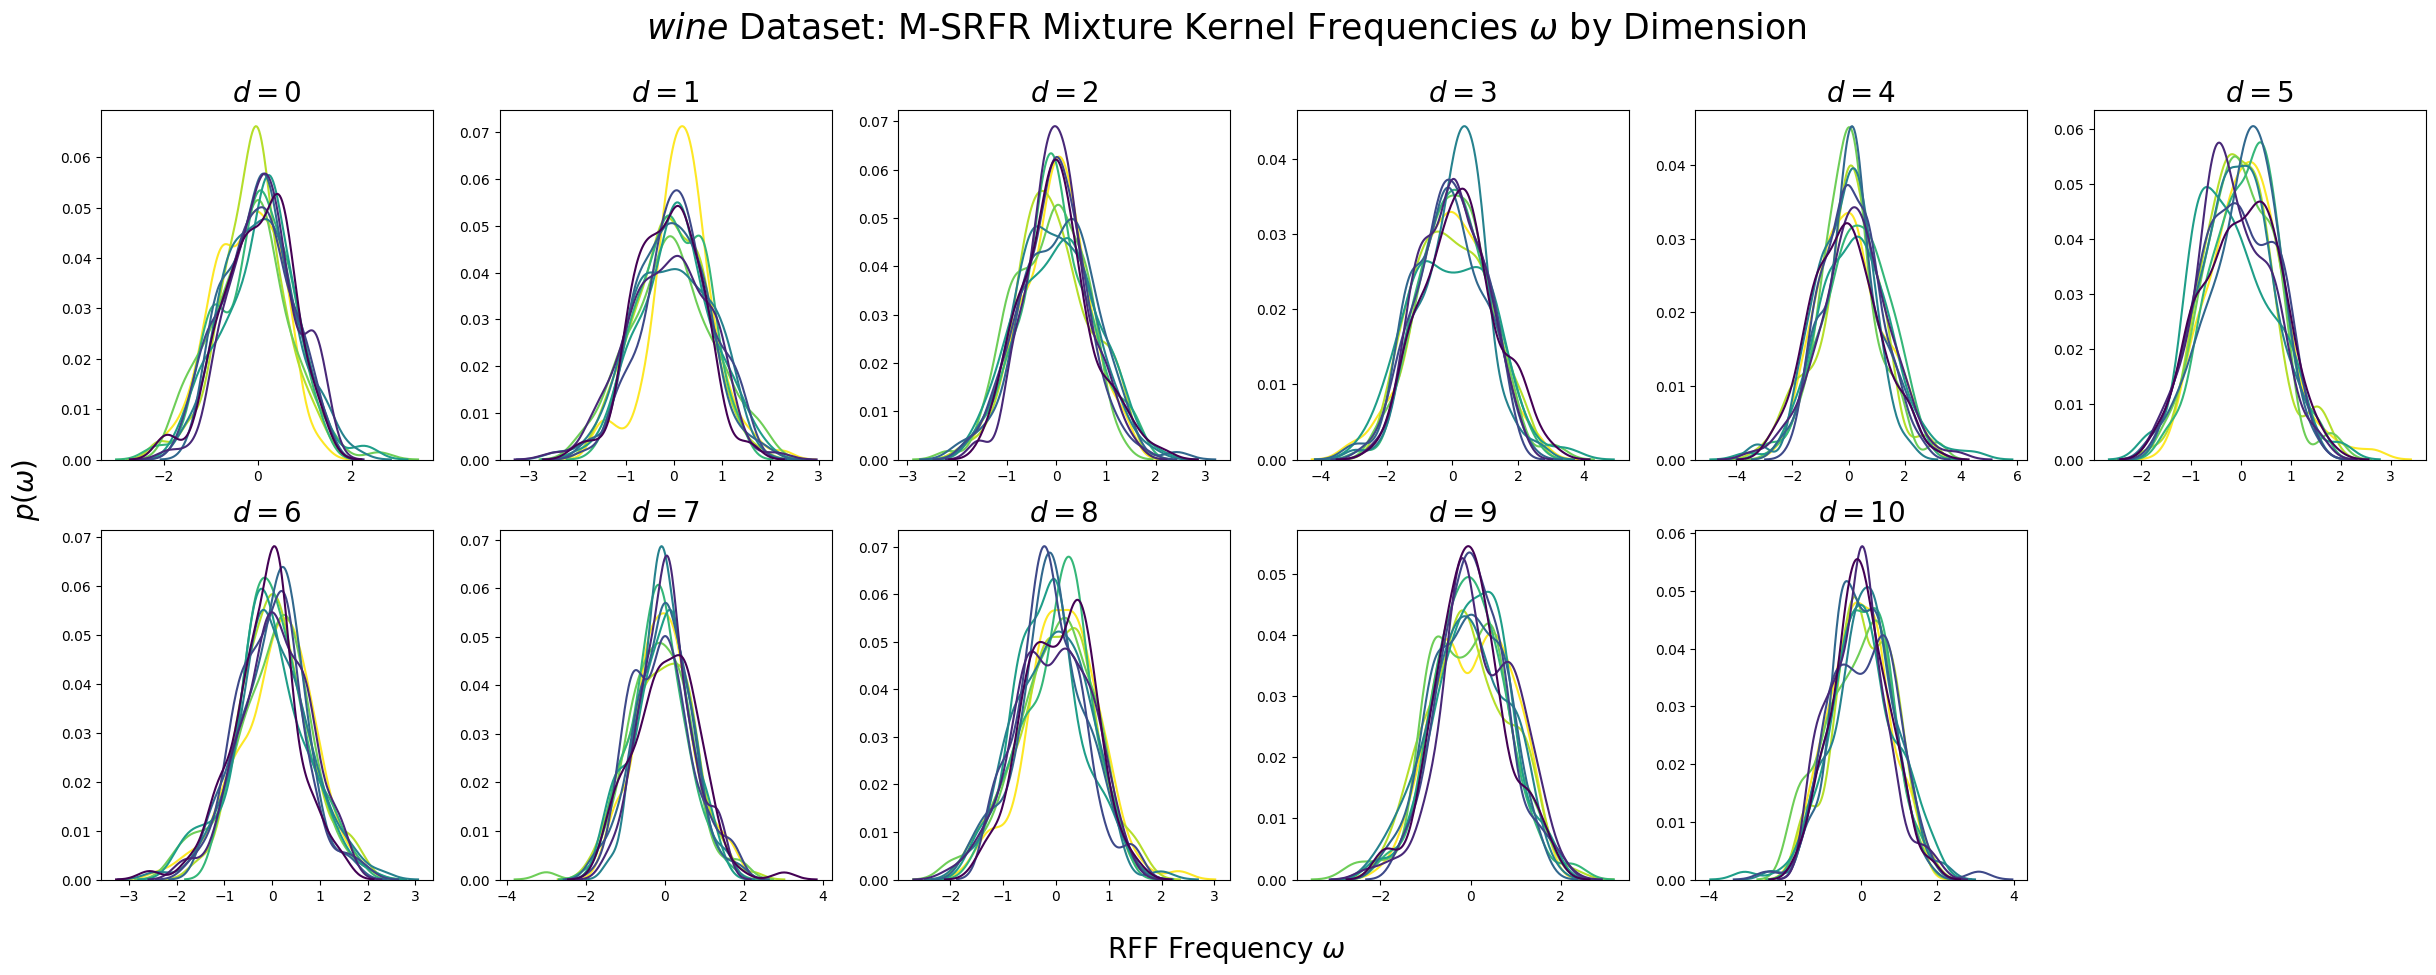

In [ ]:
kernel_plot = plot_kernel_mixture(
    mix_gp.kernel.kernel.w, 6, bw_adjust=0.85, 
    title="$\\it{AUSWAVE}$ Dataset: M-SRFR Mixture Kernel Frequencies $\omega$ by Dimension"
)
kernel_plot.savefig("auswave_kernel.pdf", bbox_inches="tight", dpi=300, format="pdf")

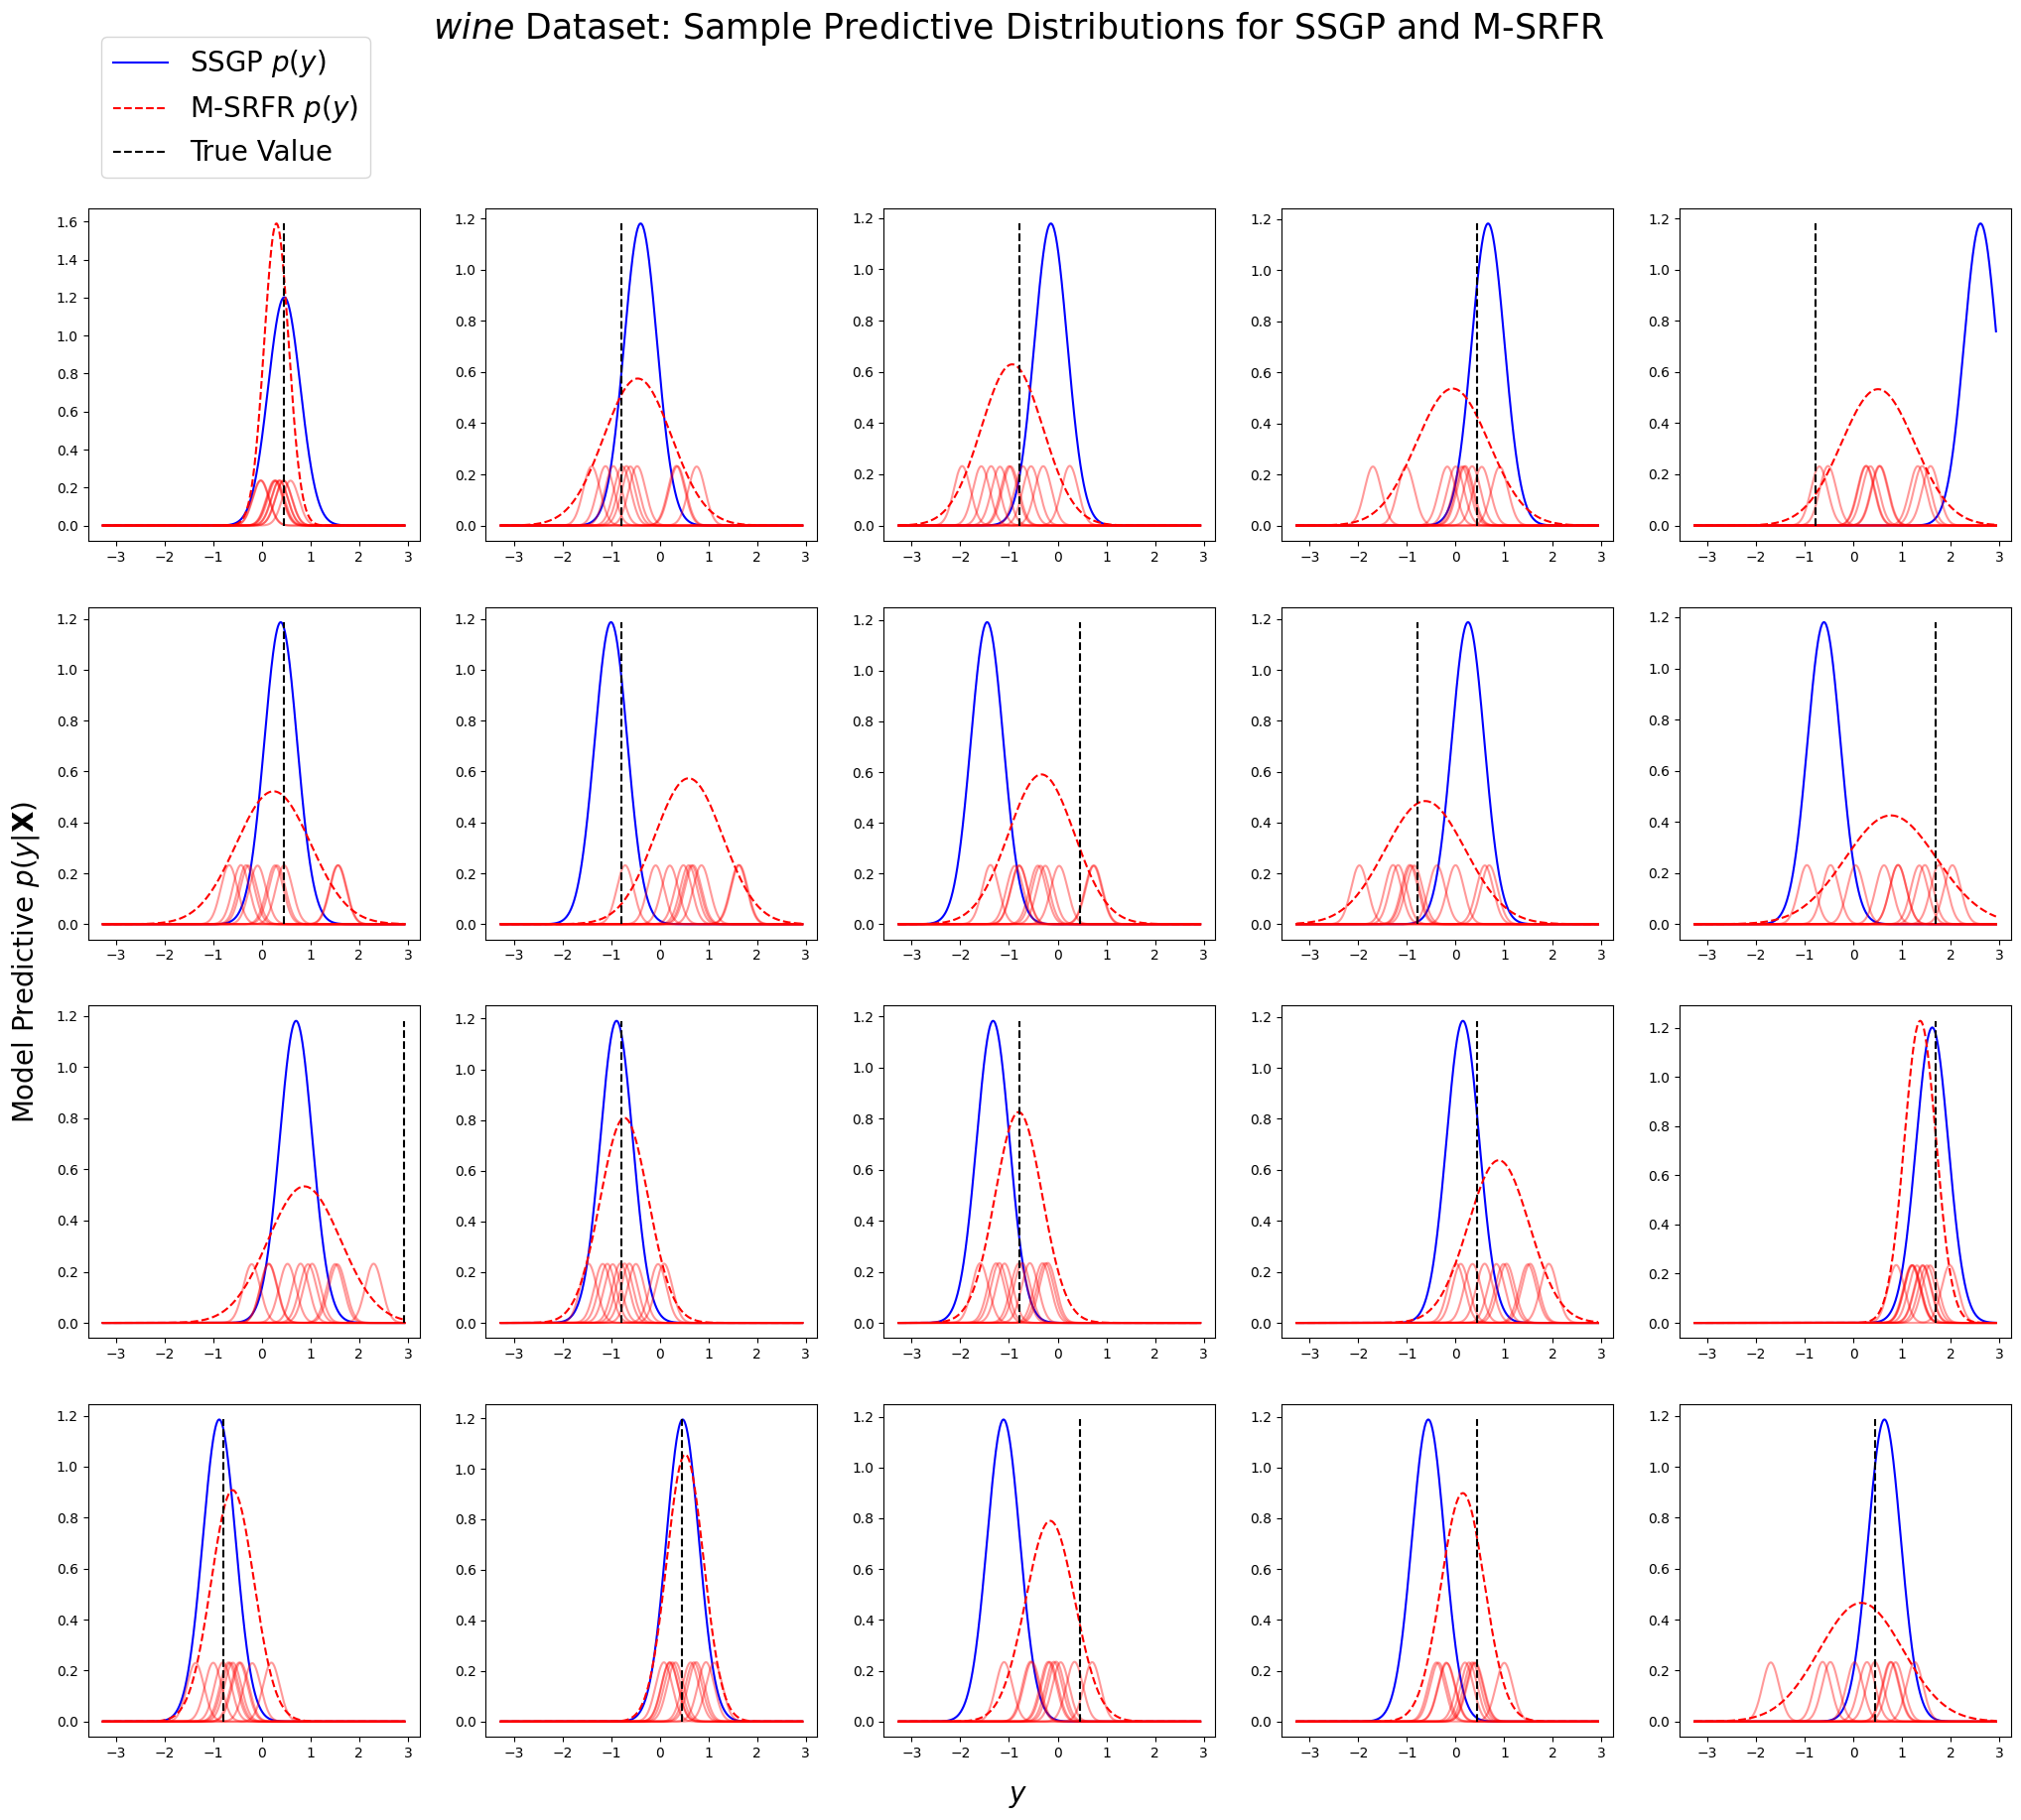

In [ ]:
plot_key = jax.random.PRNGKey(2024)
plot_bounds = jnp.array([y.min(), y.max()])
pred_plot = plot_mixture_preds(
    single_dist, mixture_dist, y_test, n=20, 
    key=plot_key, standardize=False, bounds=plot_bounds,
    title="$\\it{AUSWAVE}$ Dataset: Sample Predictive Distributions for SSGP and M-SRFR"
)
pred_plot.savefig("auswave_preds.pdf", bbox_inches="tight", dpi=300, format="pdf")